<a href="https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/d2602fefa8540ad79bd793247f67058e6c129701/projects/05-1PLXXXX_political_color_posts/results/project_report_lukas_pasold.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Machine Learning - Project Report

**Course:** Probabilistic Machine Learning (Summer Term 2025) \
**Lecturer:** Alvaro Diaz-Ruelas \
**Student Name:** Lukas Pasold \
**GitHub Username:** lukasp0910 \
**Date:** 10.06.2025   
**PROJECT-ID:** 05-1PL

## 1. Introduction

In recent national and international elections, social media has proven to be one of the most important instruments of political communication. Platforms like Instagram allow political parties to reach voters directly and shape their public image through carefully curated visual content.

This project explores whether Instagram posts from German political parties can be classified based on their dominant colors. To do this, I collected a dataset of all publicly available Instagram posts from the major German parties, dating back to the creation of each respective account, resulting in a total of approximately 28,500 posts. From each image, I extracted the four most dominant colors and used them as compact feature vectors to train a range of classifiers.

The study aims to answer the following questions: How well can simple visual features, such as dominant colors, distinguish between political parties? And how do different feature representations and preprocessing strategies affect classification performance? To address these, I evaluated different color spaces, incorporated temporal information, and applied selective data filtering to optimize model accuracy.




## 2. Data Loading and Exploration

The dataset used in this project consists of all publicly available Instagram posts from the seven major political parties in Germany: **CDU**, **CSU**, **SPD**, **FDP**, **Bündnis 90/Die Grünen**, **Die Linke**, and **AfD**. The data spans from the creation of the respective Instagram accounts, whose first posts were published between 2014 and 2019, up to December 18, 2024 and includes 28,423 posts in total. The posts were collected using a custom Python script ([`instagramdownload.py`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/instagramdownload.py)), which systematically downloaded image content and metadata from the official Instagram accounts of each party.

Due to data constraints, the full image dataset is not uploaded alongside this report. However, all images and metadata used in the analysis remain publicly accessible via the parties' official Instagram pages:


*   [CDU](https://www.instagram.com/cdu/)
*   [CSU](https://www.instagram.com/csu/)
*   [SPD](https://www.instagram.com/spd_de/)
*   [FDP](https://www.instagram.com/fdp/)
*   [Bündnis 90/Die Grünen](https://www.instagram.com/die_gruenen/)
*   [Die Linke](https://www.instagram.com/dielinke/)
*   [Afd](https://www.instagram.com/afd.bund/)

After downloading, the data was organized into a local database containing each post's image path, publication date, and party affiliation. A first overview of the dataset is given below, showing the number of posts per party:

| Party     | Number of Posts |
|-----------|-----------------|
| CDU       | 5687            |
| CSU       | 6776            |
| SPD       | 2816            |
| FDP       | 4206            |
| Grüne     | 2658            |
| Linke     | 4225            |
| AfD       | 2055            |
| **Total** | **28,423**      |

In addition, I visualized the monthly posting frequency per party over the full time span of the dataset. The resulting plot highlights general trends, variations in engagement levels, and increased activity during election periods.

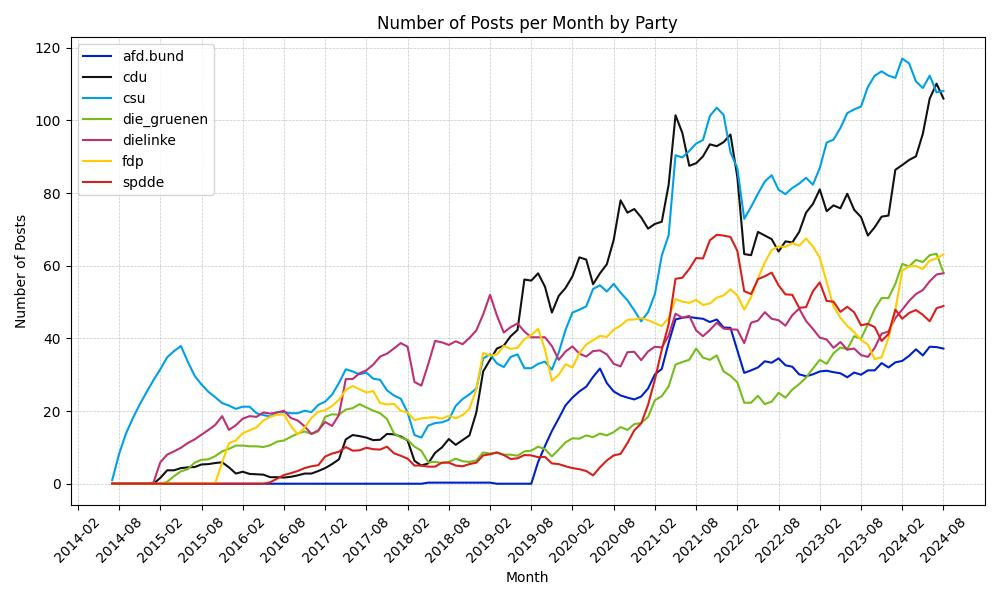

There is no missing data in the final dataset. Each post is associated with a valid timestamp, a party label, and a corresponding image. While some older posts may vary in resolution, this does not affect the feature extraction process based on color clustering.

## 3. Data Preprocessing

To prepare the dataset for machine learning, the first step was to transform the raw Instagram image data into compact and informative feature representations. For this purpose, I developed a preprocessing pipeline that extracts the dominant colors from each image using K-Means clustering. Specifically, I applied the script [`rgb_extract_colors.py`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/rgb_extract_colors.py) to extract the four most representative colors in RGB space, and the script [`hsv_extract_colors.py`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/hsv_extract_colors.py) to do the same in HSV space. Each script produced a CSV file, [`rgb_color_palettes.csv`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/data/rgb_color_palettes.csv) and [`hsv_color_palettes.csv`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/data/hsv_color_palettes.csv), respectively containing the extracted color information for every image in the dataset.

Below is a code snippet illustrating the core functionality of the RGB extraction process:
```
def extract_rgb_palette(image_path, num_colors):
    """Extracts color palette and returns feature vector."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img.width // 2, img.height // 2))
    img_array = np.array(img)

    img_rgb = img_array.reshape((-1, 3))

    kmeans = KMeans(n_clusters=num_colors, random_state=0)
    kmeans.fit(img_rgb)
    colors_rgb = kmeans.cluster_centers_
    colors_rgb = np.round(colors_rgb).astype(int)

    return colors_rgb
```
Below is a code snippet illustrating the core functionality of the HSV extraction process:
```
def extract_hsv_palette(image_path, num_colors):
    """Extracts color palette in HSV and returns feature vector."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  
    img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2))  
    
    img_hsv = img.reshape((-1, 3))  
    
    kmeans = KMeans(n_clusters=num_colors, random_state=0)
    kmeans.fit(img_hsv)
    colors_hsv = kmeans.cluster_centers_
    colors_hsv = np.round(colors_hsv).astype(int)

    return colors_hsv
```
Below is a code snippet illustrating the entire color extraction process for one sample post:

In [ ]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
# install scikit-learn if not already installed: # pip install scikit-learn
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO

def extract_rgb_palette(img, num_colors):
    """Extracts color palette and returns feature vector."""
    img = img.convert('RGB')
    img = img.resize((img.width // 2, img.height // 2))
    img_array = np.array(img)

    img_rgb = img_array.reshape((-1, 3))

    kmeans = KMeans(n_clusters=num_colors, random_state=0)
    kmeans.fit(img_rgb)
    colors_rgb = kmeans.cluster_centers_
    colors_rgb = np.round(colors_rgb).astype(int)

    return colors_rgb

def analyze_image(image_url, num_colors=4):
    # load image from URL
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # show image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    plt.show()

    # extract colors
    colors_rgb = extract_rgb_palette(img, num_colors)

    # show color palette
    plt.figure(figsize=(num_colors, 2))
    for i, color in enumerate(colors_rgb):
        plt.subplot(1, num_colors, i + 1)
        plt.imshow(np.ones((10, 10, 3), dtype=int) * color.reshape(1, 1, 3))
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)
    plt.suptitle("Extracted Colors")
    plt.show()

    # csv line
    rgb_vector = colors_rgb.flatten()
    entry = {'party': 'fdp', 'filename': '2024-10-30_17-13-48_UTC.jpg'}
    for i, value in enumerate(rgb_vector):
        entry[f'feature_{i}'] = value

    df = pd.DataFrame([entry])
    print("CSV-Line:")
    display(df)

url = 'https://raw.githubusercontent.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/refs/heads/main/projects/05-1PLXXXX_political_color_posts/data/sample_post.jpg'
analyze_image(url, num_colors=4)

Each row in these CSV files represents a single image, and the extracted colors are stored as a set of numerical features. More precisely, each feature vector consists of 12 values: one for each channel (R, G, B or H, S, V) of the four dominant colors identified by the clustering algorithm.

As a next step, I added an additional feature to both the RGB and HSV CSV files: the upload time of each Instagram post, stored in Unix time format. This was implemented using the script [`add_timestamp_feature.py`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/add_timestamp_feature.py). The motivation behind including temporal information was that several parties have significantly changed their corporate color schemes over the years. By incorporating the upload time, I aimed to help the classifiers adjust to these temporal shifts in visual branding and potentially improve overall classification performance.

As a final preprocessing step, I addressed a key challenge with the dataset. Many posts do not prominently feature the party’s corporate colors, which makes color-based classification difficult and reduces overall performance. To counter this, I trained a Random Forest Classifier on the entire dataset and used cross-validation to estimate prediction confidence for each post. This was implemented in the notebook [`color_relevance_estimation.ipynb`](https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/color_relevance_estimation.ipynb). Based on the results, I added two new columns to both the RGB and HSV CSV files. The first, confidence, contains the predicted probability for the assigned class. The second, relevant, is a binary indicator set to 1 whenever the confidence exceeds a threshold of 0.4. This enables filtering the dataset for posts with strong color signals, which are more likely to reflect the parties' visual identity. The distribution of confidence scores across all posts is illustrated in the two plots below, one for each color space.

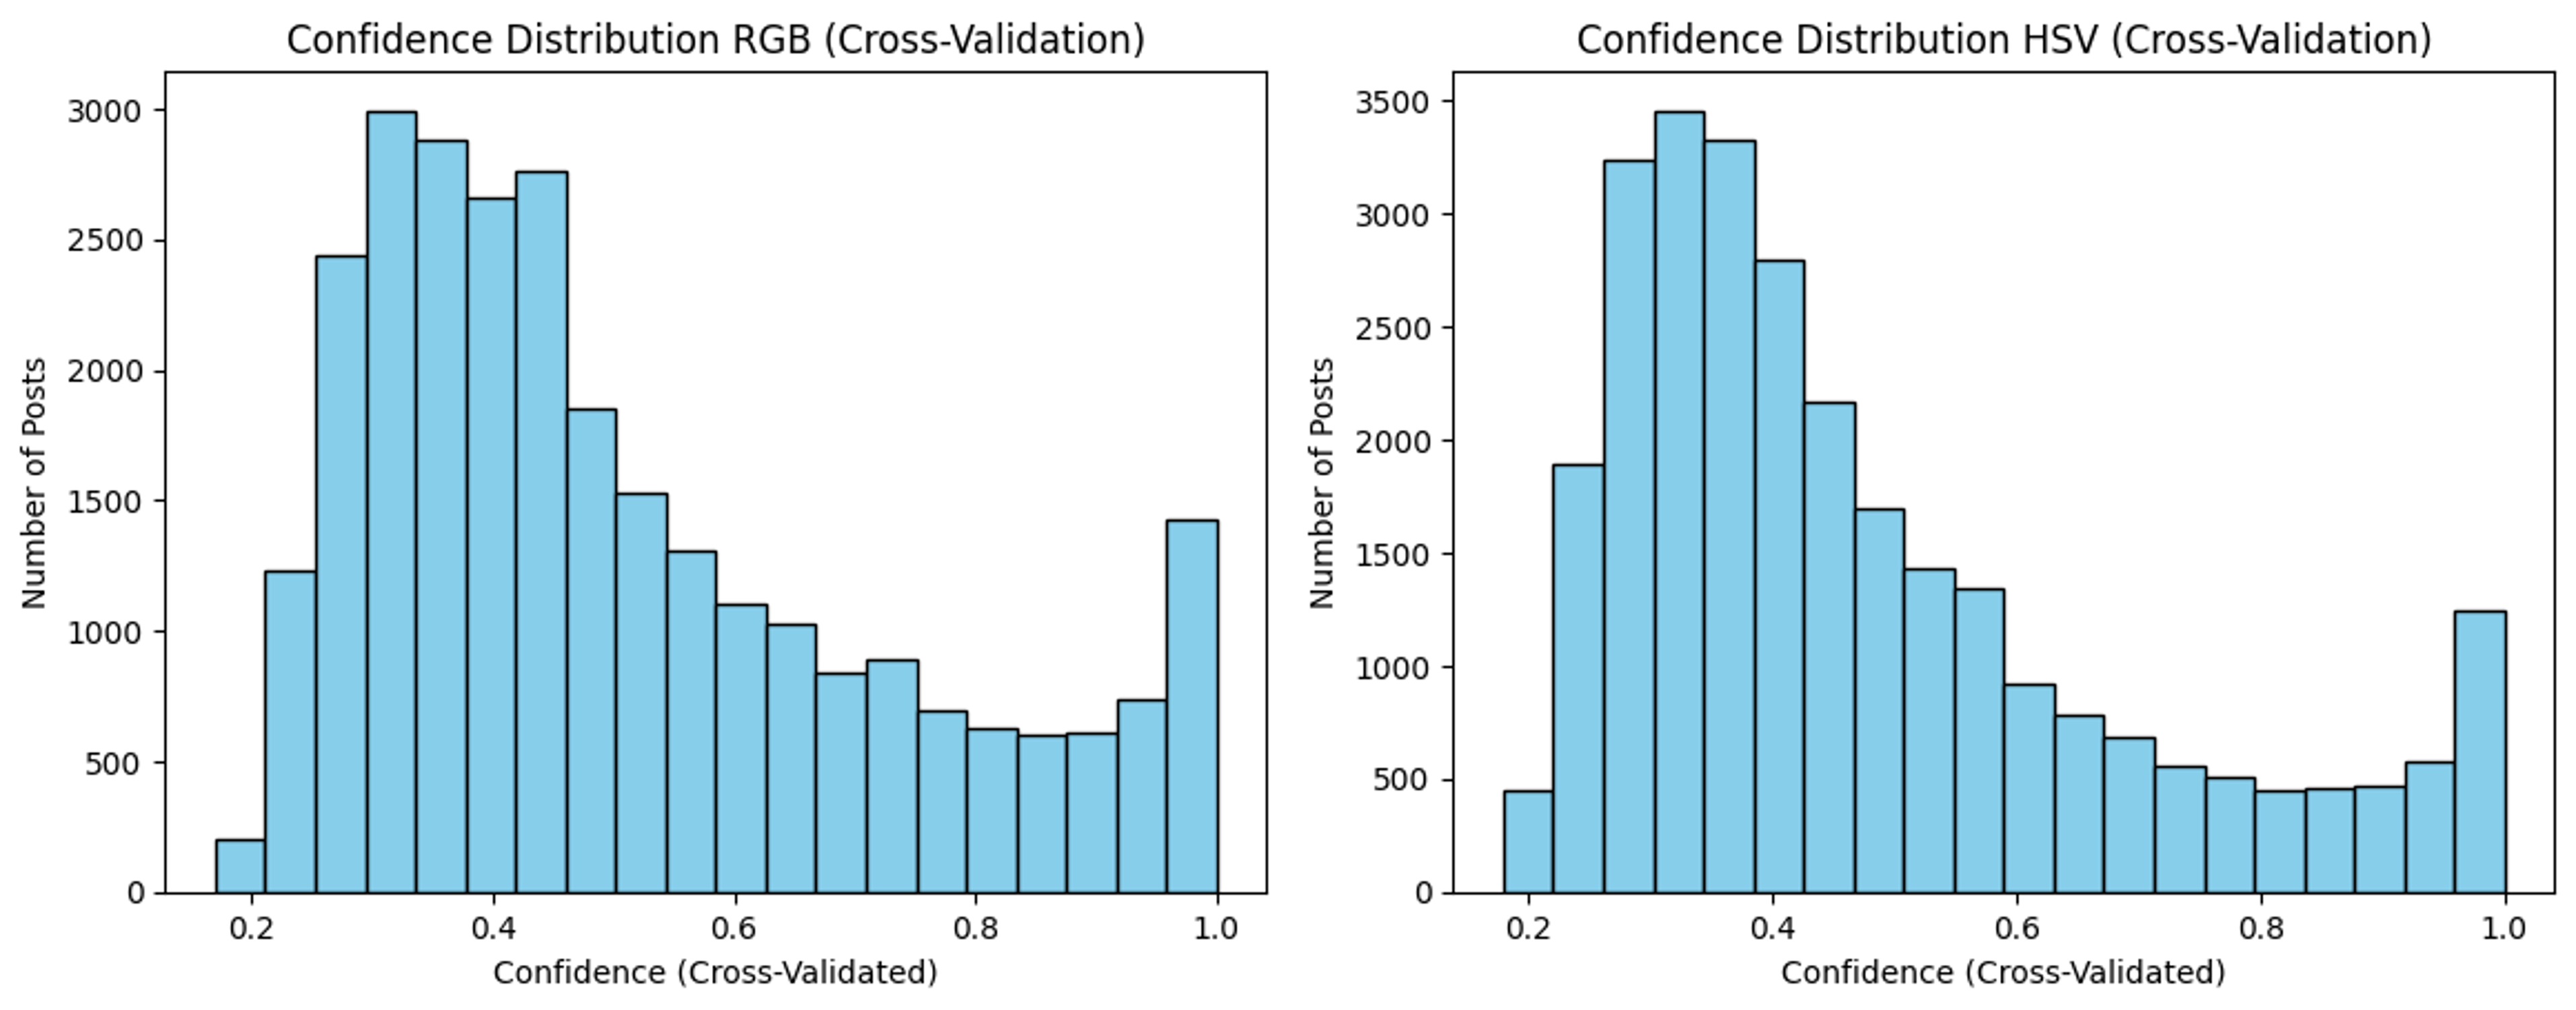

The final preprocessed feature datasets, incorporating both the extracted color palette features and the additional metadata columns are stored in the files [`final-features-rgb.csv`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/data/final-features-rgb.csv) and [`final-features-hsv.csv`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/data/final-features-hsv.csv). Below is a preview of some rows of the RGB feature table:

| party | filename                        | feature_0 | feature_1 | feature_2 | feature_3 | feature_4 | feature_5 | feature_6 | feature_7 | feature_8 | feature_9 | feature_10 | feature_11 | date       | feature_12 | confidence | relevant |
|--------|--------------------------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-------------|-------------|------------|-------------|-------------|----------|
| spd    | 2024-04-16_09-03-47_UTC.jpg    | 90        | 49        | 50        | 207       | 195       | 180       | 227       | 96        | 56        | 21        | 11          | 10          | 2024-04-16 | 1713225600  | 0.24        | 0        |
| spd    | 2024-04-18_11-19-41_UTC.jpg    | 41        | 37        | 31        | 216       | 16        | 22        | 251       | 242       | 238       | 213       | 148         | 127         | 2024-04-18 | 1713398400  | 0.41        | 1        |
| spd    | 2024-04-21_08-03-51_UTC.jpg    | 23        | 17        | 16        | 249       | 238       | 235       | 225       | 2         | 14        | 192       | 137         | 115         | 2024-04-21 | 1713657600  | 0.82        | 1        |
| spd    | 2024-04-22_14-32-27_UTC.jpg    | 252       | 247       | 247       | 226       | 2         | 16        | 20        | 47        | 109       | 235       | 172         | 52          | 2024-04-22 | 1713744000  | 0.49        | 1        |
| spd    | 2024-04-23_08-21-30_UTC.jpg    | 12        | 12        | 13        | 161       | 130       | 120       | 247       | 244       | 243       | 84        | 62          | 55          | 2024-04-23 | 1713830400  | 0.29        | 0        |

## 4. Probabilistic Modeling Approach

To classify Instagram posts according to party affiliation based on extracted color features, I applied four different classification models: Random Forest, XGBoost, Support Vector Machine (SVM), and Multilayer Perceptron (MLP) Classifier. Each of these models represents a distinct approach to pattern recognition and brings its own strengths to the classification problem.

Random Forest follows an ensemble-based strategy by combining the outputs of many decision trees. Each tree is trained on a different subset of the data and features, introducing diversity into the model. When predicting the class of a new input, each tree casts a “vote” for one of the possible parties, and the class with the majority of votes is chosen as the final output. Additionally, because each tree can output class probabilities, the average over all trees gives a measure of predictive confidence. This ensemble approach is particularly robust to noise and overfitting, making it a reliable choice when dealing with real-world image data. [[1]](#ref-breiman2001)[[5]](#ref-rodriguez2012)

XGBoost, short for extreme Gradient Boosting, is another ensemble learning method that builds upon the concept of decision trees. Unlike Random Forest, which uses a bagging approach (training trees independently), XGBoost employs a boosting strategy. It sequentially builds trees, where each new tree aims to correct the errors made by the previously trained trees. This iterative refinement process allows XGBoost to progressively focus on misclassified instances, leading to a highly accurate and robust model. Furthermore, XGBoost incorporates regularization techniques to prevent overfitting, making it efficient and scalable, especially when dealing with large datasets and complex feature interactions. This makes it a strong contender for tasks requiring high predictive power and computational efficiency. [[7]](#ref-chen2016)

The SVM model, on the other hand, is based on geometric principles. It seeks to find the optimal hyperplane that best separates the different classes in the feature space. The main objective is to maximize the margin between the closest data points from different classes, ensuring a decision boundary that generalizes well to unseen data. Even if the classes cannot be separated in the original space, the SVM can transform the data into a higher-dimensional space where separation becomes possible. This makes SVM especially well-suited for cases where class boundaries are subtle, as it focuses on the most informative data points near the class borders. [[2]](#ref-cortes1995)[[4]](#ref-hsu2016)

The MLP Classifier introduces a fundamentally different, neural-network-based approach. It consists of several layers of interconnected units that learn hierarchical representations of the input features. Each layer applies non-linear transformations, allowing the model to capture complex interactions and non-obvious patterns in the data. The training process adjusts the connection weights to minimize classification error across all examples. This makes MLPs particularly powerful in settings where the relation between features and classes is non-linear and cannot be easily described by simple geometric boundaries. [[3]](#ref-goodfellow2016)[[6]](#ref-rumelhart1986)

## 5. Model Training and Evaluation

To train and evaluate the classification models, I systematically explored different combinations of input features and data subsets across both color spaces, RGB and HSV. For each color space, I applied all four classifiers Random Forest, XGBoost, SVM, and MLP, using three different setups. First, I trained the models using only the twelve color features extracted from the image palettes. In a second setup, I added the upload time as an additional feature. Finally, I trained the models using only those posts that had been marked as relevant based on their classification confidence. This setup aimed to assess how additional temporal information and the exclusion of visually ambiguous images influence the performance of the classifiers.

To prepare the data for model training, I first separated the feature matrix from the target labels.

```
# For Setup 1
  X = df[[f'feature_{i}' for i in range(12)]]
  y = df['party']

# For Setup 2
  X = df[[f'feature_{i}' for i in range(13)]]
  y = df['party']

# For Setup 3
  X = df[[f'feature_{i}' for i in range(13)]]
  y = df['party']
  relevant = df['relevant']
  mask = (relevant == 1)
  X = X[mask]
  y = y[mask]
```

Next, I split the dataset into training and test portions. This split was done in a way that maintains the distribution of classes across both sets, ensuring that each class is represented proportionally.

```
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
```

Once the data was prepared, I trained the classifiers on the training data and evaluated their performance on the test set. Each model was fitted and tested separately for all combinations of feature sets and color spaces. All classifiers were configured with `class_weight='balanced'` and `random_state=42` to handle class imbalances and to ensure consistent results across runs. The Random Forest classifier uses 100 trees by default. The XGBoost was configured with `eval_metric='mlogloss'`. For the SVM, feature scaling was applied using `StandardScaler` to transform the data to zero mean and unit variance. This step is essential for SVMs because the algorithm relies on distance calculations, and features with larger scales could otherwise dominate the learning process. The MLP was configured with two hidden layers of 128 and 64 neurons, respectively, using the ReLU activation function to introduce non-linearity and allow for the learning of complex patterns. The initial learning rate was set to 0.001 to ensure stable weight updates, and training was allowed to run for up to 1000 iterations (`max_iter=1000`). A small L2 regularization term (`alpha=0.0001`) was included to reduce the risk of overfitting by penalizing large weights.

```
# 1. Random Forest
  rf = RandomForestClassifier(class_weight='balanced', random_state=42)
  rf.fit(X_train, y_train)
  y_pred_rf = rf.predict(X_test)
  report_rf = classification_report(y_test, y_pred_rf)

# 2. XGBoost
  # Encode the target variable
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  y_train_encoded = le.fit_transform(y_train)
  y_test_encoded = le.transform(y_test)

  xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
  xgb.fit(X_train, y_train_encoded)
  y_pred_xgb_encoded = xgb.predict(X_test)

  # Decode the predictions back to original labels for classification report
  y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

  report_xgb = classification_report(y_test, y_pred_xgb)

# 3. Support Vector Machine (SVM)
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
  svm.fit(X_train_scaled, y_train)
  y_pred_svm = svm.predict(X_test_scaled)
  report_svm = classification_report(y_test, y_pred_svm)

# 4. MLP Classifier
  mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    learning_rate_init=0.001,
    max_iter=1000,
    alpha=0.0001,
    random_state=42
  )
  mlp.fit(X_train_scaled, y_train)
  y_pred_mlp = mlp.predict(X_test_scaled)
  report_mlp = classification_report(y_test, y_pred_mlp)
```

To evaluate model performance, I focused on the F1-score, which provides a balanced measure of precision and recall and is well-suited to multi-class classification tasks with uneven class distributions. After completing all training and evaluation runs, I compiled a table of the resulting F1-scores for each configuration. This final overview provides a comparative view of how each model and feature setup performed, highlighting the impact of time-based features and confidence filtering on classification accuracy.

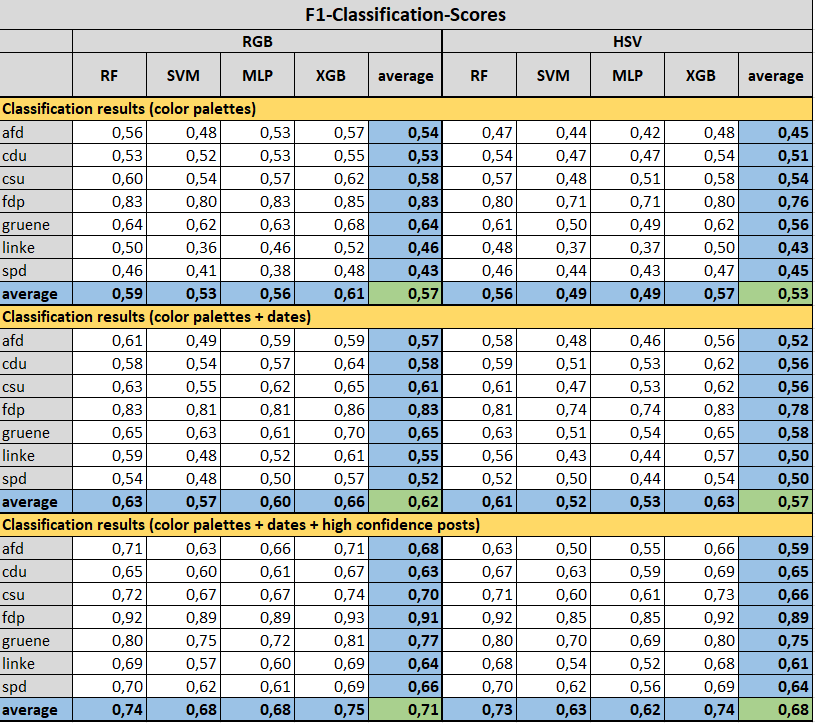

The training processes, including data preparation, model fitting, and evaluation, are documented in the notebooks [`classification_setup1.ipynb`](https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/classification_setup1.ipynb), [`classification_setup2.ipynb`](https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/classification_setup2.ipynb), and [`classification_setup3.ipynb`](https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/classification_setup3.ipynb). These notebooks also contain more detailed insights into model behavior beyond just the F1-scores.

## 6. Results

The classification results based on F1 scores reveal clear patterns across different feature setups, classifiers, and color spaces. Among the four classifiers tested, the XGBoost consistently achieved the highest performance in all scenarios, closely followed by the Random Forest. SVM generally performed the worst, while MLP achieved mid-range results, occasionally performing on par with SVM in the most refined setup.

Comparing the three setups, it becomes evident that the inclusion of additional features leads to substantial improvements in classification performance. Using only color palette features (Setup 1) yielded an average F1 score of 0.57 across all classifiers. Adding the publication dates of posts (Setup 2) raised the average to 0.61, and incorporating only high-confidence posts (Setup 3) further increased the score to 0.71.

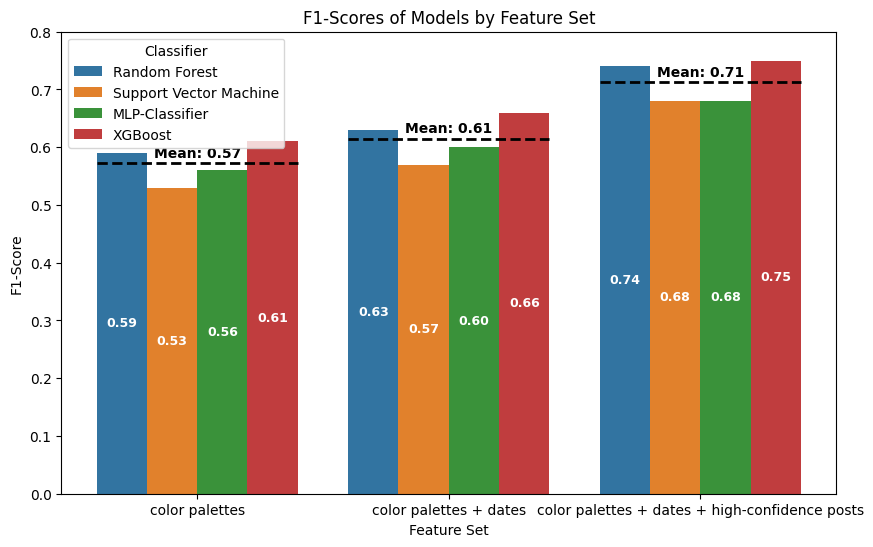

Regarding color spaces, the RGB representation consistently outperformed HSV across all three setups. While the differences were not dramatic, they were systematic. For instance, in Setup 3, the RGB-based models achieved an average F1 score of 0.71, compared to 0.68 in HSV. This indicates that RGB may better preserve relevant visual features in the context of this classification task.


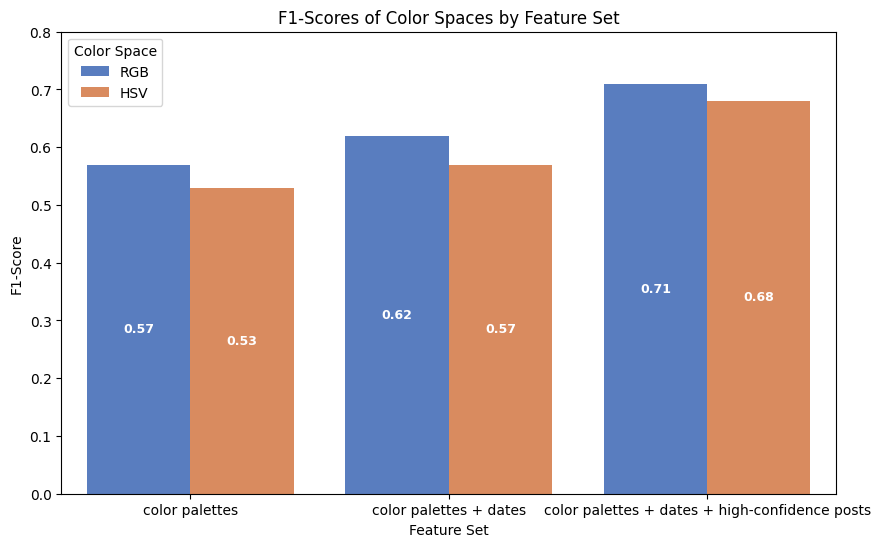

Analyzing party-specific performance further supports these findings. In Setup 3 with RGB features, some parties—particularly the FDP (0.93), CSU (0.74), and the Greens (0.81) achieved notably high F1 scores. These results suggest that their visual branding is especially consistent or distinctive. By contrast, parties like the CDU (0.67) and the Left (0.69) performed less strongly, although they still saw major improvements over the previous setups.

## 7. Discussion

The results indicate that while dominant color features carry some predictive value for identifying the party affiliation of Instagram posts, their effectiveness varies significantly across parties. Classification performance was generally better for parties that tend to use more consistent and saturated color schemes in their visual communication whereas parties with more varied or minimalist designs were harder to identify based solely on color. This suggests that the presence of party-related color elements is not uniformly distributed and may depend on party-specific communication strategies or campaign phases.

Several limitations of the current approach should be acknowledged. One key limitation is that the corporate design of political parties is not static and may change over time especially during different election cycles or rebranding efforts. While this temporal variability is partially accounted for by including the date of the post as a feature it may not be sufficient to fully capture shifts in visual identity. Another major limitation lies in the nature of the data itself since many posts in the dataset do not prominently feature any of the party’s recognizable colors or only include them in very small proportions. Consequently relying on dominant colors extracted via clustering may lead to a misrepresentation of the visual identity in these cases. Additionally the choice to extract only four dominant colors per image may be too restrictive and potentially miss relevant color information in more complex visual compositions. The machine learning models used were also relatively simple and not specifically optimized for this task leaving room for potential improvement through more tailored model selection or parameter tuning.

Future improvements could involve experimenting with a larger number of color clusters or using perceptually uniform color spaces such as CIELAB or CIECAM02 which are designed so that equal distances in the color space correspond to roughly equal perceptual differences. Incorporating additional visual features beyond color such as shapes logos or text regions could also significantly enhance classification accuracy. On the modeling side more sophisticated architectures such as convolutional neural networks trained directly on image data might capture richer representations of the visual content. Moreover the temporal component could be modeled in a more fine-grained way for example by using time-series models or recurrent neural networks to explicitly learn how visual strategies evolve over time or by incorporating contextual metadata such as the proximity to elections campaign phases or specific political events.



## 8. Conclusion

This project set out to explore whether the dominant colors of Instagram posts by German political parties could be used to predict their party affiliation using probabilistic machine learning methods. The overarching research questions concerned the extent to which visual features, specifically color, encode political identity, and how different feature representations and preprocessing strategies affect classification performance.

The results show that although certain parties tend to use specific colors in their posts, such as the Greens favoring green tones and the SPD frequently using red, these patterns were not distinct or stable enough across the dataset to support strong predictive performance. The classifiers achieved only moderate accuracy, indicating that dominant color alone does not carry sufficient discriminatory information for reliable classification. This suggests that political communication through visual media is more nuanced and cannot be captured by single visual features in isolation.

The second research question focused on the impact of different preprocessing strategies and feature representations. In this regard, the analysis revealed that choices such as the color extraction method, the number of clusters in k-means, and the color space representation did have measurable but limited effects on model performance. While some variations led to slight improvements, none of the configurations overcame the fundamental limitations posed by the reduction of complex images to single color features. The reliance on dominant color as the primary input constrained the models' ability to capture more subtle visual cues that may contribute to political branding.

In summary, the results demonstrate that while color can carry some political signal, using dominant color alone leads to relatively weak prediction outcomes. These limitations, discussed in detail earlier, help explain the modest performance of the models. To answer the research questions, it can be concluded that color-based classification is feasible in principle but not reliable in practice unless supported by richer feature sets. Future research should consider integrating additional visual characteristics or multimodal data to more effectively model the visual strategies employed by political actors on social media.



## 9. References

<a name="ref-breiman2001"></a>
[1] Breiman, L. (2001). Random forests. *Machine Learning, 45*(1), 5–32.

<a name="ref-cortes1995"></a>
[2] Cortes, C., & Vapnik, V. (1995). Support-vector networks. *Machine Learning, 20*(3), 273–297.

<a name="ref-goodfellow2016"></a>
[3] Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep learning*. MIT Press.

<a name="ref-hsu2016"></a>
[4] Hsu, C.-W., Chang, C.-C., & Lin, C.-J. (2016). *A practical guide to support vector classification*. National Taiwan University.

<a name="ref-rodriguez2012"></a>
[5] Rodríguez-Galiano, V. F., Ghimire, B., Rogan, J., Chica-Olmo, M., & Rigol-Sanchez, J. P. (2012). An assessment of the effectiveness of a random forest classifier for land-cover classification. *ISPRS Journal of Photogrammetry and Remote Sensing, 67*, 93–104.

<a name="ref-rumelhart1986"></a>
[6] Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. *Nature, 323*(6088), 533–536.

<a name="ref-chen2016"></a>
[7] Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 785–794.